In [40]:
import pandas as pd
import numpy as np
import os, re
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
import survivors.datasets as ds
import survivors.constants as cnt

%load_ext line_profiler
%load_ext scalene

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


### Структура

Вариант 1: стратифицированные модели

Вариант 2: стратифицированные модели только на категориальных

Вариант 3: стратифицированные и стекинговые модели

Результаты:
1. Таблица средних по разной глубине и сравнение с деревом и базовой моделью (3 набора)
2. График зависимости качества от глубины (разные методы на одном графике) 

Выводы:
1. Обработка категориальных без расслоения
2. Обработка пропусков (умное заполнение)
3. Излишняя глубина приводит к проблемам со сходимостью и схожести выборок
4. Лучшее качество на глубине 2-4

In [17]:
glob_dir = os.path.join(os.path.split(os.path.split(os.getcwd())[0])[0], "experiment_results", "Backblaze")

========== backblaze16_18 ==========


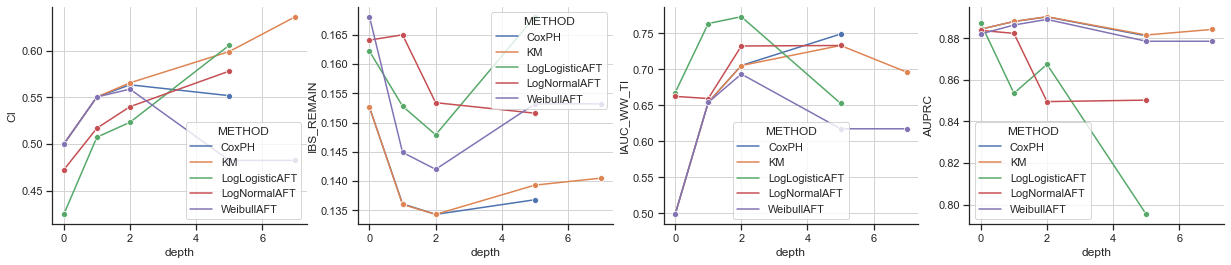

            METHOD        CI IBS_REMAIN IAUC_WW_TI     AUPRC depth
0            CoxPH       0.5     0.1526     0.4985    0.8843     0
1            CoxPH    0.5504     0.1361     0.6541     0.888     1
2            CoxPH    0.5634   *0.1343*     0.7053  *0.8902*     2
3            CoxPH    0.5518     0.1368    *0.749*    0.8811     5
4               KM       0.5     0.1526     0.4985    0.8843     0
5               KM    0.5504    *0.136*     0.6541     0.888     1
6               KM    0.5655   *0.1343*     0.7052  *0.8903*     2
7               KM  *0.5989*     0.1393     0.7331    0.8815   *5*
8               KM  *0.6362*     0.1405     0.6961    0.8842   *7*
9   LogLogisticAFT    0.4249     0.1622     0.6676    0.8871     0
10  LogLogisticAFT    0.5074     0.1528   *0.7636*    0.8535     1
11  LogLogisticAFT    0.5233     0.1479   *0.7731*    0.8674     2
12  LogLogisticAFT  *0.6056*     0.1681     0.6527    0.7953     5
13    LogNormalAFT    0.4725     0.1641     0.6624    0.8837  

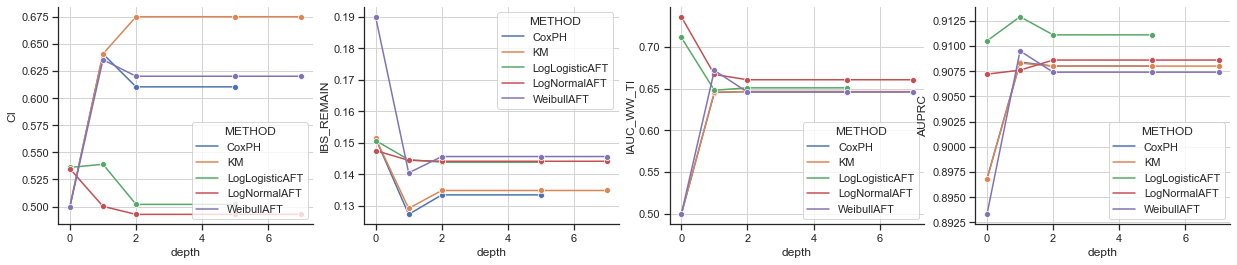

            METHOD        CI IBS_REMAIN IAUC_WW_TI     AUPRC depth
0            CoxPH       0.5     0.1514     0.4992    0.8968     0
1            CoxPH    0.6408   *0.1272*     0.6455    0.9084     1
2            CoxPH    0.6104   *0.1334*     0.6466     0.908     2
3            CoxPH    0.6104     0.1334     0.6466     0.908     5
4               KM       0.5     0.1514     0.4992    0.8968     0
5               KM    0.6408   *0.1291*     0.6459    0.9083     1
6               KM  *0.6751*     0.1348     0.6466     0.908     2
7               KM  *0.6751*     0.1348     0.6466     0.908     5
8               KM  *0.6751*     0.1348     0.6466     0.908   *7*
9   LogLogisticAFT    0.5361     0.1507   *0.7117*    0.9105     0
10  LogLogisticAFT     0.539     0.1446     0.6482  *0.9129*     1
11  LogLogisticAFT     0.502     0.1438     0.6511  *0.9111*     2
12  LogLogisticAFT     0.502     0.1438     0.6511  *0.9111*     5
13    LogNormalAFT    0.5349     0.1475   *0.7365*    0.9072  

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\vasiliev\\Desktop\\PycharmProjects\\dev-survivors\\experiment_results\\Backblaze\\IBS_REMAIN_STRAT_TREE_backblaze21_23_CV_full.xlsx'

In [71]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM",
    "BaseLeafModeLL": "KM",
    "deepsurvCRAID": "DeepSurv",
    "coxtimeCRAID": "CoxTime"}

BASE_MODELS = ["KM", "CoxPH", "WeibullAFT"]

STAT_m = ['BaseLeafModeLL']
ML_m = ["CoxPH", 'ST']
SELF_m = ['TREE', 'TREE_KMWV']

def parse_br(text):
    pattern = re.compile(r'\((\d+)\)')
    match = pattern.search(text)
    if match:
        return int(match.group(1))
    return 0

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
#         m = s[1]
        m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
    d = str(x["depth"])
    if len(d) > 0:
        return fr"{l_m}+{m}({d})"
#         return fr"${m}({cr})$"
    return fr"{m}"

def find_best_index(df):
    ens_name = "IBS_REMAIN"
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top_index[:3]
    else:
        top3_index = top_index[-3:]
#     column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    column.iloc[top3_index] = "*" + column.iloc[top3_index].astype(str) + "*"
    return column

def rank_values(column, filter_self=False):
    top_index = column.argsort().argsort()
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        return top_index + 1
    return top_index.shape[0] - top_index

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:   
        datasets_sc = f"{c_m}_STRAT_TREE_{dataset}_CV_full.xlsx"
#         datasets_sc = f"{c_m}_STRATTIME+_tree_{dataset}_CV_full.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"]
        dfs.append(df_sc)
    
#         datasets_sc = f"{c_m}_STRATTIME+_scsurv_{dataset}_CV_full.xlsx"
#         dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    
    df = pd.concat(dfs, ignore_index=True)
    
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    df["l_m"] = df["l_m"].replace({"base":"KM"})
    df["depth"] = df["PARAMS"].apply(lambda x: eval(x).get("depth", ""))
    df["METHOD"] = df.apply(define_name, axis=1)
    df = df[~df["METHOD"].isin(["$RSF$", "$GBSA$", "$CWGBSA$"])]
    df = df.loc[df.groupby('METHOD')["IBS_REMAIN_mean"].idxmin()]
    df["METHOD"] = df["METHOD"].astype("category")
    
#     f, axes = plt.subplots(1, 4, figsize=(21, 4))
    l_df = []
    for i, v in enumerate(tg_metrs_1):
        df[new_metrs[i]] = df[tg_metrs_1[i]]
        v = new_metrs[i]
        df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
        explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
#         l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.4f}"))
        l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: round(x.mean(), 4)))
        
#         axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
#         axes[i].set_ylabel(v)
#         axes[i].set_title("")
        
    res_table = pd.concat(l_df, axis=1)#.astype(float).round(4)
    res_table = res_table.reset_index(drop=False)
    pattern = re.compile(r'\((\d+)\)')
    res_table["depth"] = res_table["METHOD"].apply(parse_br)
    res_table["METHOD"] = res_table["METHOD"].apply(lambda x: x.split("+")[0])
#     print(res_table)
    
    f, axes = plt.subplots(1, 4, figsize=(21, 4))
    sns.lineplot(res_table, x="depth", y="CI", hue="METHOD", ax=axes[0], marker="o")
    sns.lineplot(res_table, x="depth", y="IBS_REMAIN", hue="METHOD", ax=axes[1], marker="o")
    sns.lineplot(res_table, x="depth", y="IAUC_WW_TI", hue="METHOD", ax=axes[2], marker="o")
    sns.lineplot(res_table, x="depth", y="AUPRC", hue="METHOD", ax=axes[3], marker="o")
    plt.show()
    res_table["METHOD"] = list(map(lambda x: x.replace("\lambda",'l'), res_table["METHOD"]))
    res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
#     res_table.index = "$" + res_table.index + "$"
    
    res_table_star = res_table.copy()
    res_table_star = res_table_star.apply(add_star_top3)
    print(res_table_star)
#     res_table_star.to_csv(os.path.join(glob_dir, f"{dataset}_agg.csv"), sep="&")
#     plt.suptitle("")
#     plt.show()
    return res_table.apply(rank_values) # df

ch_metrs = ["IBS_REMAIN"]
df_l = []
for ds in ["backblaze16_18", "backblaze18_21", "backblaze21_23"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, "", ch_metrs)
    df_l.append(df)

In [46]:
df_l

[]